In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
import random
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_tree

In [2]:
data = pd.read_csv("vars_final_zscale.csv", index_col = 0)

In [3]:
# Look at the data
data.head()

,Fraud,Card_Amount_Act_median_30D,Card_Merch_Amount_max_7D,v_num_card_amount_card14,v_num_card_amount_card7,v_num_merch_amount_card7,v_num_merch_amount_merch14,Card_Merch_Amount_max_30D,Card_State_Amount_max_30D,Card_State_Amount_max_14D,...,Card_Zip_Amount_total_3D,Card_Zip_Amount_max_3D,Card_Zip_Amount_median_3D,Card_Zip_Amount_mean_3D,Card_Amount_median_14D,Card_Merch_Amount_median_7D,Card_State_Amount_mean_30D,Card_State_Amount_mean_14D,v_amount_card_num_card7,Card_Merch_Amount_mean_14D
Recnum,,,,,,,,,,,,,,,,,,,,,
1,0,-0.120119,-0.158959,5.871008,4.898253,0.501112,5.898894,-0.175484,-0.231773,-0.203669,...,-0.127423,-0.156257,-0.188153,-0.188405,-0.245421,-0.188017,-0.194931,-0.196986,-0.472119,-0.187477
2,0,-0.120119,-0.160996,0.518050,0.338047,-0.096451,0.551609,-0.177512,-0.233739,-0.205665,...,-0.128918,-0.158296,-0.190803,-0.191053,-0.248927,-0.190735,-0.197738,-0.199734,-0.411548,-0.190208
3,0,-0.120119,-0.125551,-0.057104,-0.151928,-0.115540,-0.070261,-0.142209,-0.199517,-0.170932,...,-0.102904,-0.122819,-0.144685,-0.144963,-0.187902,-0.143425,-0.148884,-0.151906,-0.091059,-0.142679
4,0,-0.120119,-0.162273,5.697684,4.750597,0.827875,5.898894,-0.178785,-0.234972,-0.206917,...,-0.129855,-0.159574,-0.192465,-0.192714,-0.251127,-0.192440,-0.199498,-0.201458,-0.471886,-0.191920
5,0,-0.120119,-0.158959,5.871008,4.898253,0.501112,5.898894,-0.175484,-0.231773,-0.203669,...,-0.127423,-0.156257,-0.188153,-0.188405,-0.245421,-0.188017,-0.194931,-0.196986,-0.472119,-0.187477


In [4]:
# split data into out of date(after 11/1/10), train and test
oot_df = data.iloc[84300:,:]
trte_df = data.iloc[:84299,:]

In [5]:
#split training and testing
train, test = train_test_split(trte_df, test_size=0.2,random_state=0)
        
# split lables and features 
train_lab = train["Fraud"]
train_fea = train.iloc[:,1:16]

test_lab = test["Fraud"]
test_fea = test.iloc[:,1:16]

oot_lab=oot_df["Fraud"]
oot_fea=oot_df.iloc[:,1:16]

#define model
model=XGBClassifier(max_depth=3, 
            learning_rate=0.1, 
            n_estimators=500, 
            subsample=0.8, 
            gamma=1)   #modify based on your model

#fit model
model.fit(train_fea,train_lab) #modify based on your model

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=1, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [6]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

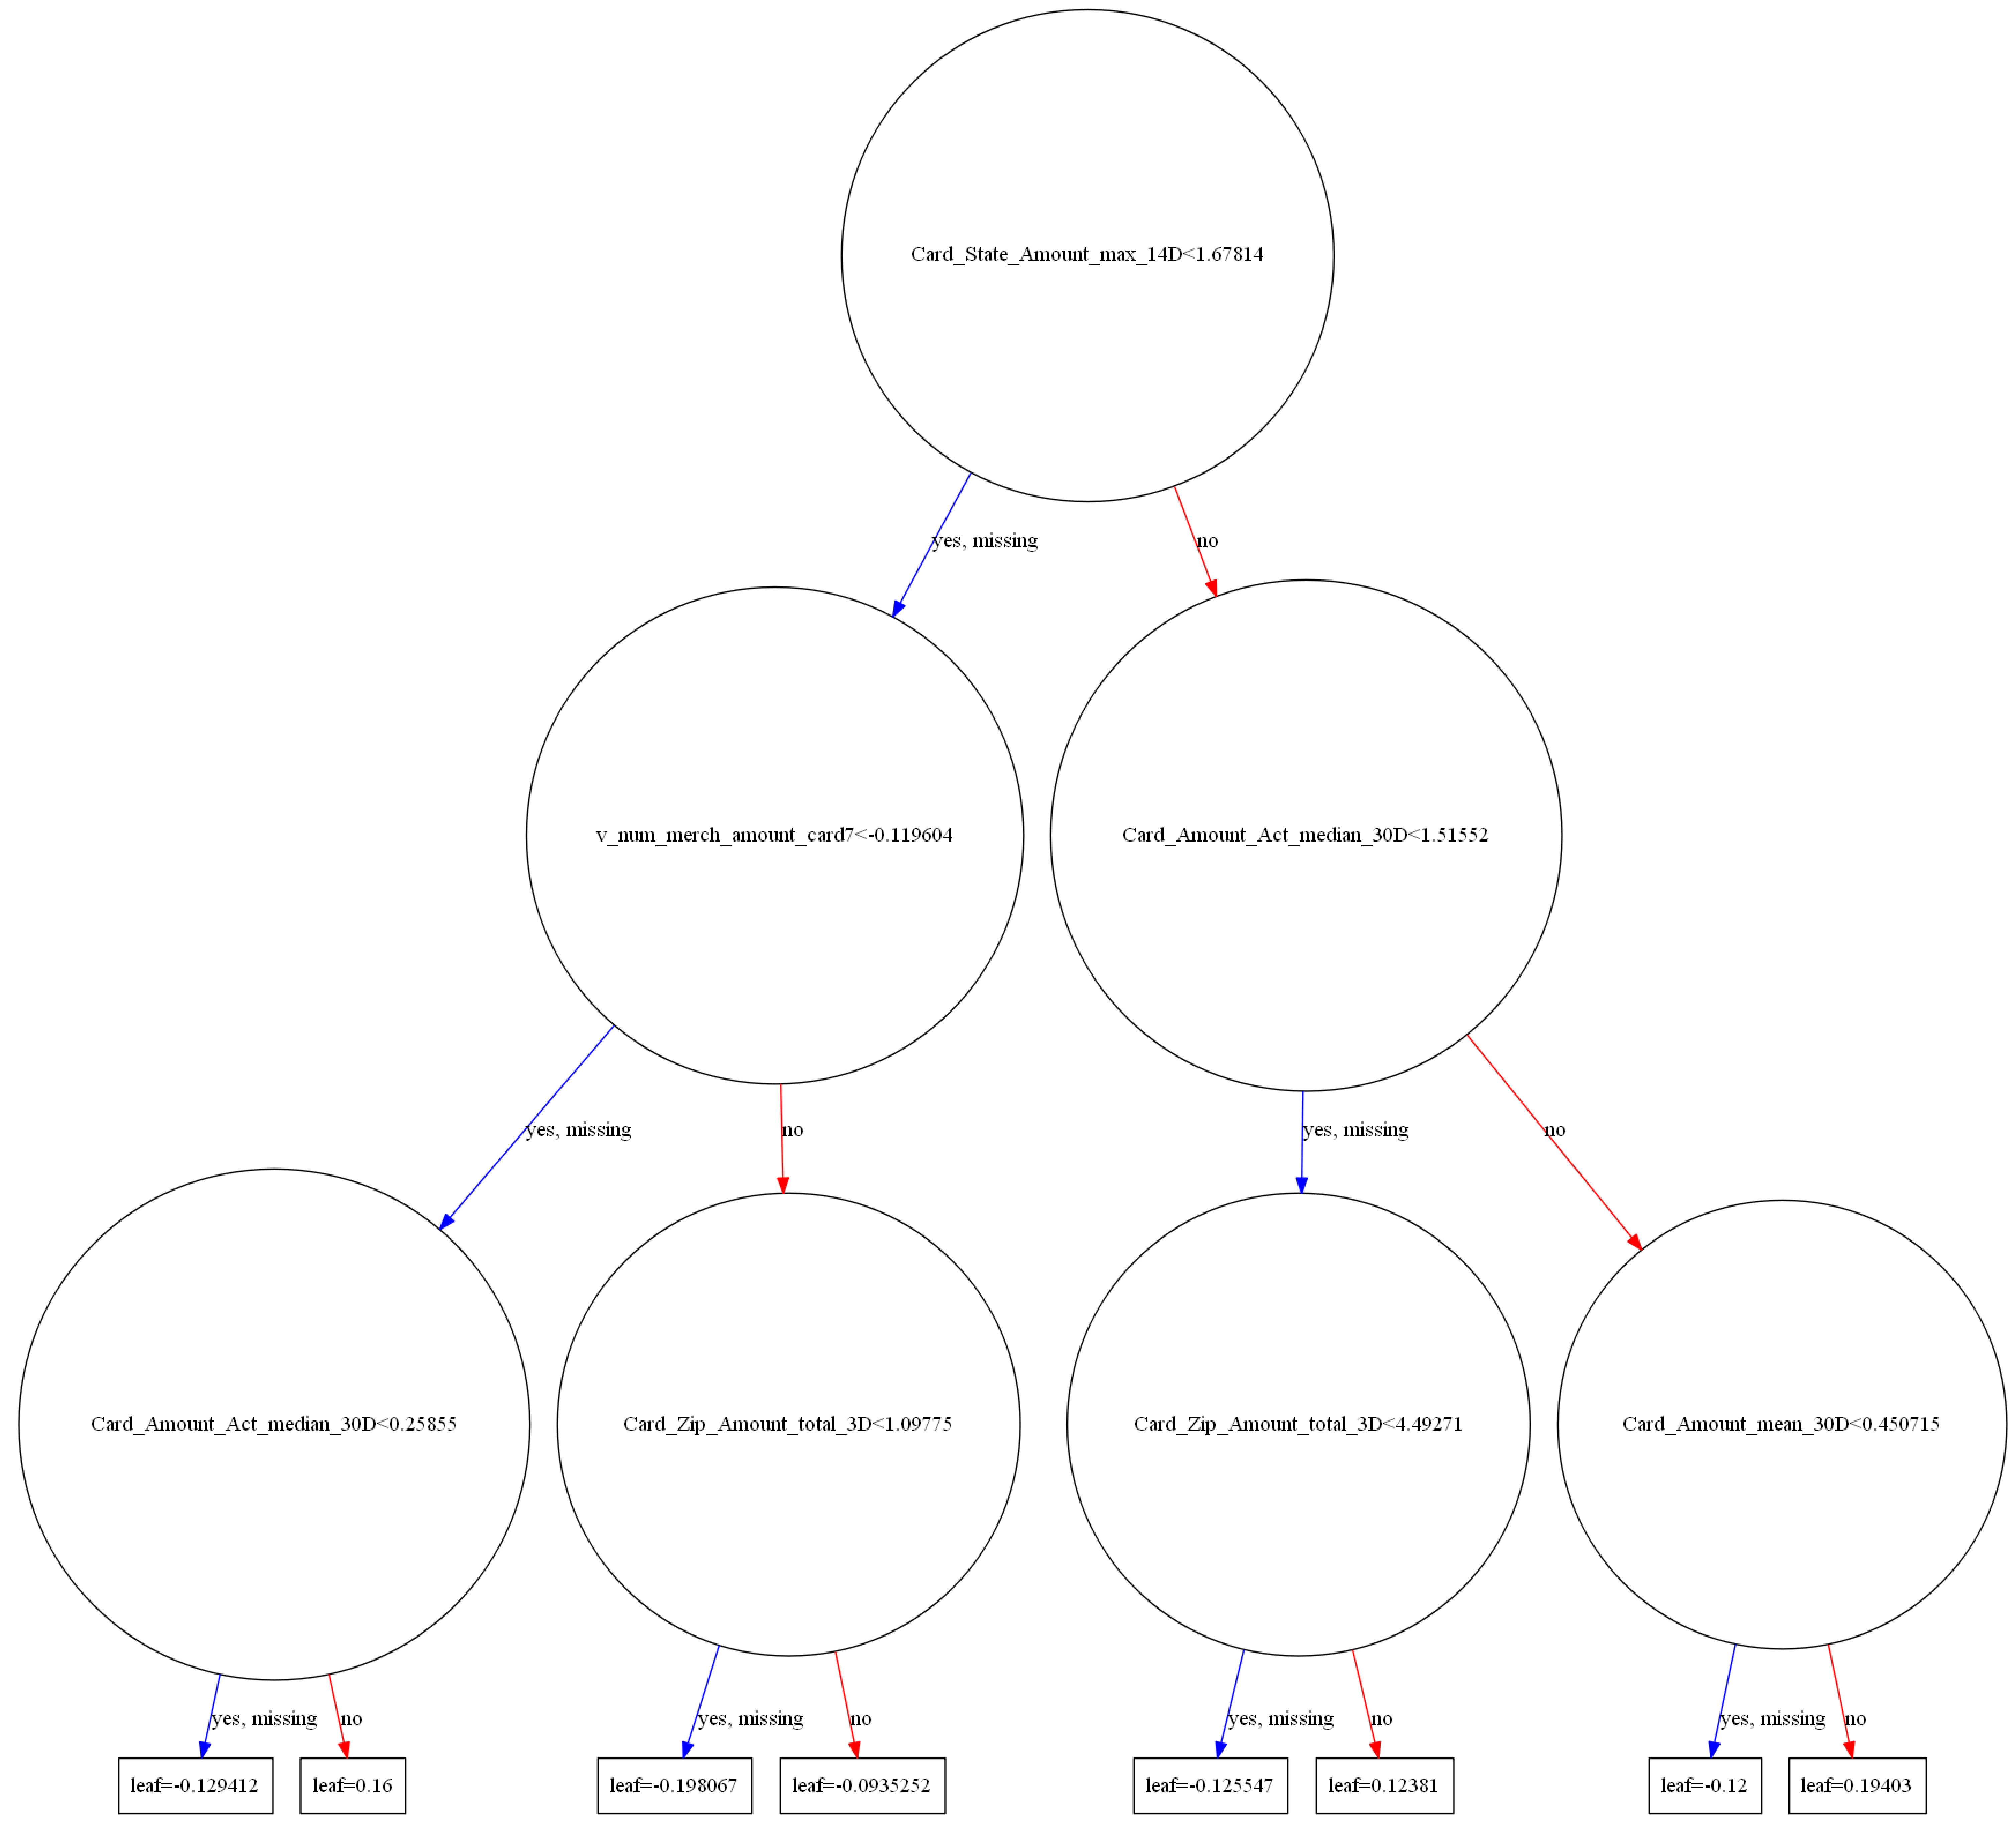

In [8]:
plot_tree(model)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

In [9]:
def Table(fea,lab):    
        
    prob=pd.DataFrame(model.predict_proba(fea))
    result=pd.concat([pd.DataFrame(lab).reset_index(),prob],axis=1)
    sort=result[['Fraud',1]].sort_values(by=1,ascending=False)
    sort=sort.reset_index().reset_index()

    groups=sort.groupby(pd.cut(sort.level_0,100))

    #initialize 
    CumRecord=0
    CumGood=0
    CumBad=0
    TotalGoods=len(sort[sort["Fraud"]==0])
    TotalBads=len(sort[sort["Fraud"]==1])

    GoodsPer=[]
    BadsPer=[]
    CumRecords=[]
    CumGoods=[]
    CumBads=[]
    CumGoodsPer=[]
    CumBadsPer=[]
    KS=[]
    FPR=[]

    bins=np.linspace(1,20,20)
    Records=groups.count().Fraud
    Goods=Records-(groups.sum().Fraud)
    Bads=groups.sum().Fraud

    #Convert series into a list
    RecordsList=Records.tolist()[:20]
    GoodsList=Goods.tolist()[:20]
    BadsList=Bads.tolist()[:20]

    for i in range(20):
        Record=RecordsList[i]
        Good=GoodsList[i]
        Bad=BadsList[i]

        GoodPer=Good/Record
        BadPer=Bad/Record
        CumRecord+=Record
        CumGood+=Good
        CumBad+=Bad
        CumGoodPer=CumGood/TotalGoods
        CumBadPer=CumBad/TotalBads

        GoodsPer.append(GoodPer)
        BadsPer.append(BadPer)
        CumRecords.append(CumRecord)
        CumGoods.append(CumGood)
        CumBads.append(CumBad)
        CumGoodsPer.append(CumGoodPer)
        CumBadsPer.append(CumBadPer)
        KS.append(CumBadPer-CumGoodPer)
        FPR.append(CumGood/CumBad)

    table=pd.DataFrame([bins.tolist(),RecordsList,GoodsList,BadsList,GoodsPer,BadsPer,
                      CumRecords,CumGoods,CumBads,
                      CumGoodsPer,CumBadsPer,KS,FPR]).transpose()
    table.columns=["Population Bin %","# Records","# Goods","# Bads",
                      "% Goods", "% Bads", "Total # Records",
                      "Cumulative Good","Cumulative Bad","% Good",
                      "% Bad (FDR)","KS","FPR"]                            
    return (table)

In [10]:
Table(train_fea,train_lab)

,Population Bin %,# Records,# Goods,# Bads,% Goods,% Bads,Total # Records,Cumulative Good,Cumulative Bad,% Good,% Bad (FDR),KS,FPR
0,1.0,675.0,5.0,670.0,0.007407,0.992593,675.0,5.0,670.0,0.000075,0.912807,0.912732,0.007463
1,2.0,674.0,622.0,52.0,0.922849,0.077151,1349.0,627.0,722.0,0.009400,0.983651,0.974252,0.868421
2,3.0,675.0,672.0,3.0,0.995556,0.004444,2024.0,1299.0,725.0,0.019474,0.987738,0.968265,1.791724
3,4.0,674.0,672.0,2.0,0.997033,0.002967,2698.0,1971.0,727.0,0.029548,0.990463,0.960915,2.711142
4,5.0,674.0,671.0,3.0,0.995549,0.004451,3372.0,2642.0,730.0,0.039607,0.994550,0.954943,3.619178
5,6.0,675.0,672.0,3.0,0.995556,0.004444,4047.0,3314.0,733.0,0.049681,0.998638,0.948956,4.521146
6,7.0,674.0,674.0,0.0,1.000000,0.000000,4721.0,3988.0,733.0,0.059786,0.998638,0.938852,5.440655
7,8.0,675.0,674.0,1.0,0.998519,0.001481,5396.0,4662.0,734.0,0.069890,1.000000,0.930110,6.351499
8,9.0,674.0,674.0,0.0,1.000000,0.000000,6070.0,5336.0,734.0,0.079994,1.000000,0.920006,7.269755
9,10.0,674.0,674.0,0.0,1.000000,0.000000,6744.0,6010.0,734.0,0.090098,1.000000,0.909902,8.188011


In [27]:
Table(test_fea,test_lab)

,Population Bin %,# Records,# Goods,# Bads,% Goods,% Bads,Total # Records,Cumulative Good,Cumulative Bad,% Good,% Bad (FDR),KS,FPR
0,1.0,169.0,46.0,123.0,0.272189,0.727811,169.0,46.0,123.0,0.002752,0.842466,0.839714,0.373984
1,2.0,169.0,160.0,9.0,0.946746,0.053254,338.0,206.0,132.0,0.012325,0.904110,0.891785,1.560606
2,3.0,168.0,163.0,5.0,0.970238,0.029762,506.0,369.0,137.0,0.022077,0.938356,0.916279,2.693431
3,4.0,169.0,169.0,0.0,1.000000,0.000000,675.0,538.0,137.0,0.032189,0.938356,0.906168,3.927007
4,5.0,168.0,166.0,2.0,0.988095,0.011905,843.0,704.0,139.0,0.042120,0.952055,0.909934,5.064748
5,6.0,169.0,168.0,1.0,0.994083,0.005917,1012.0,872.0,140.0,0.052172,0.958904,0.906732,6.228571
6,7.0,169.0,169.0,0.0,1.000000,0.000000,1181.0,1041.0,140.0,0.062283,0.958904,0.896621,7.435714
7,8.0,168.0,168.0,0.0,1.000000,0.000000,1349.0,1209.0,140.0,0.072335,0.958904,0.886570,8.635714
8,9.0,169.0,168.0,1.0,0.994083,0.005917,1518.0,1377.0,141.0,0.082386,0.965753,0.883367,9.765957
9,10.0,168.0,168.0,0.0,1.000000,0.000000,1686.0,1545.0,141.0,0.092437,0.965753,0.873316,10.957447


In [28]:
Table(oot_fea,oot_lab)

,Population Bin %,# Records,# Goods,# Bads,% Goods,% Bads,Total # Records,Cumulative Good,Cumulative Bad,% Good,% Bad (FDR),KS,FPR
0,1.0,121.0,70.0,51.0,0.578512,0.421488,121.0,70.0,51.0,0.005873,0.284916,0.279043,1.372549
1,2.0,121.0,92.0,29.0,0.760331,0.239669,242.0,162.0,80.0,0.013593,0.446927,0.433334,2.025000
2,3.0,121.0,115.0,6.0,0.950413,0.049587,363.0,277.0,86.0,0.023242,0.480447,0.457205,3.220930
3,4.0,121.0,108.0,13.0,0.892562,0.107438,484.0,385.0,99.0,0.032304,0.553073,0.520769,3.888889
4,5.0,121.0,114.0,7.0,0.942149,0.057851,605.0,499.0,106.0,0.041869,0.592179,0.550309,4.707547
5,6.0,121.0,119.0,2.0,0.983471,0.016529,726.0,618.0,108.0,0.051854,0.603352,0.551498,5.722222
6,7.0,121.0,118.0,3.0,0.975207,0.024793,847.0,736.0,111.0,0.061755,0.620112,0.558356,6.630631
7,8.0,121.0,120.0,1.0,0.991736,0.008264,968.0,856.0,112.0,0.071824,0.625698,0.553874,7.642857
8,9.0,121.0,119.0,2.0,0.983471,0.016529,1089.0,975.0,114.0,0.081809,0.636872,0.555062,8.552632
9,10.0,121.0,119.0,2.0,0.983471,0.016529,1210.0,1094.0,116.0,0.091794,0.648045,0.556251,9.431034


In [ ]:
#############

In [34]:
def data(df):
    print("# Records:",len(df))
    print("# Goods:",len(df)-sum(df))
    print("# Bads:",sum(df))
    print("Fraud Rate:",sum(df)/len(df))

In [35]:
data(train_lab)

# Records: 67439
# Goods: 66705
# Bads: 734
Fraud Rate: 0.010883909903764883


In [36]:
data(test_lab)

# Records: 16860
# Goods: 16714
# Bads: 146
Fraud Rate: 0.008659549228944246


In [37]:
data(oot_lab)

# Records: 12097
# Goods: 11918
# Bads: 179
Fraud Rate: 0.014797057121600397


In [40]:
pd.DataFrame(list(train_fea))

,0
0,Card_Amount_Act_median_30D
1,Card_Merch_Amount_max_7D
2,v_num_card_amount_card14
3,v_num_card_amount_card7
4,v_num_merch_amount_card7
5,v_num_merch_amount_merch14
6,Card_Merch_Amount_max_30D
7,Card_State_Amount_max_30D
8,Card_State_Amount_max_14D
9,Card_Amount_mean_30D


# Fraud Savings Calculation

In [80]:
def FraudSaving(t=20,g=100):    
        
    prob=pd.DataFrame(model.predict_proba(oot_fea))
    result=pd.concat([pd.DataFrame(oot_lab).reset_index(),prob],axis=1)
    sort=result[['Fraud',1]].sort_values(by=1,ascending=False)
    sort=sort.reset_index().reset_index()

    groups=sort.groupby(pd.cut(sort.level_0,g))

    bins=(np.linspace(1,g,100)/g)*100
    Records=groups.count().Fraud
    Goods=Records-(groups.sum().Fraud)
    Bads=groups.sum().Fraud

    #Convert series into a list
    binsList=bins.tolist()[:t]
    RecordsList=Records.tolist()[:t]
    GoodsList=Goods.tolist()[:t]
    BadsList=Bads.tolist()[:t]

    #declare list
    FraudSavingL=[]
    LostSalesL=[]
    OverallSavingL=[]
    
    #initialize
    FraudSaving=0
    LostSales=0
    OverallSaving=0
    
    for i in range(t):
        Record=RecordsList[i]
        Good=GoodsList[i]
        Bad=BadsList[i]

        FraudSaving+=2000*Bad
        LostSales+=50*Good
        OverallSaving+=2000*Bad-50*Good
        
        FraudSavingL.append(FraudSaving)
        LostSalesL.append(LostSales)
        OverallSavingL.append(OverallSaving)


    table=pd.DataFrame([binsList,RecordsList,GoodsList,BadsList,
                        FraudSavingL,LostSalesL,OverallSavingL]).transpose()
    table.columns=["Population Bin %","# Records","# Goods","# Bads",
                     "Fraud Saving","Lost Sales","Overall Savings"]                            
    return (table)

In [81]:
FraudSavingT=FraudSaving(t=100)
FraudSavingT

,Population Bin %,# Records,# Goods,# Bads,Fraud Saving,Lost Sales,Overall Savings
0,1.0,121.0,70.0,51.0,102000.0,3500.0,98500.0
1,2.0,121.0,92.0,29.0,160000.0,8100.0,151900.0
2,3.0,121.0,115.0,6.0,172000.0,13850.0,158150.0
3,4.0,121.0,108.0,13.0,198000.0,19250.0,178750.0
4,5.0,121.0,114.0,7.0,212000.0,24950.0,187050.0
5,6.0,121.0,119.0,2.0,216000.0,30900.0,185100.0
6,7.0,121.0,118.0,3.0,222000.0,36800.0,185200.0
7,8.0,121.0,120.0,1.0,224000.0,42800.0,181200.0
8,9.0,121.0,119.0,2.0,228000.0,48750.0,179250.0
9,10.0,121.0,119.0,2.0,232000.0,54700.0,177300.0


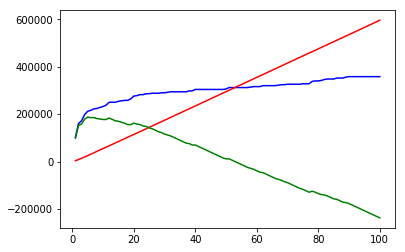

In [82]:
plt.plot('Population Bin %',"Fraud Saving",data=FraudSavingT,color='blue')
plt.plot('Population Bin %',"Lost Sales",data=FraudSavingT,color='red')
plt.plot('Population Bin %',"Overall Savings",data=FraudSavingT,color='green')
plt.show()

In [83]:
FraudSavingT["Overall Savings"].max()

187050.0

In [84]:
FraudSavingT.to_csv("Fraud Saving.csv")